In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist

### Data Loading + Processing

PBMC immune cells from Seurat/CCA alignment

In [2]:
dat = pd.read_csv('immune_data.csv')

In [3]:
meta = pd.read_csv('immune_meta.csv')

In [4]:
dat1 = meta['x'] == 'IMMUNE_CTRL'
dat2 = meta['x'] == 'IMMUNE_STIM'

In [5]:
dat_array = dat.values[:,1:]

In [6]:
print(dat_array.shape)

(14053, 14039)


In [7]:
ctrl = dat_array[:,dat1.values]
print(ctrl.shape)

(14053, 6573)


In [8]:
stim = dat_array[:,dat2.values]
print(stim.shape)

(14053, 7466)


In [9]:
dat_pre = dat = pd.read_csv('immune_pre.csv')
dat_pre.head()

,Unnamed: 0,AAACATACATTTCC.1,AAACATACCAGAAA.1,AAACATACCTCGCT.1,AAACATACCTGGTA.1,AAACATACGATGAA.1,AAACATACGGCATT.1,AAACATACTGCGTA.1,AAACATACTGCTGA.1,AAACATTGAGTGTC.1,...,TTTGACTGCCCTAC.1,TTTGACTGCTACCC.1,TTTGACTGCTTGGA.1,TTTGACTGGCGAAG.1,TTTGACTGGGTACT.1,TTTGCATGAACGAA.1,TTTGCATGACGTAC.1,TTTGCATGCCTGTC.1,TTTGCATGCTAAGC.1,TTTGCATGGGACGA.1
0,AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,RP11-206L10.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LINC00115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NOC2L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KLHL17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
dat_pre_array = dat_pre.values[:,1:]
ctrl_pre = dat_pre_array[:,dat1.values]
stim_pre = dat_pre_array[:,dat2.values]
print(ctrl_pre.shape)

(14053, 6573)


### Topography Preservation

In [21]:
def markov_matrix(dat,length):
    x = dist.cdist(dat,dat)/length
    y = np.exp(x) - np.eye(len(x))
    row_sum = np.sum(x,axis = 0)
    z = np.divide(x,row_sum)
    return z

In [12]:
def KNN(dat,K):
    x = dist.cdist(dat,dat)
    z = np.zeros((dat.shape[0],K))
    #print(z)
    for i in range(0,len(dat)):
        y = np.argsort(x[i,:])
        #print(i)
        #print(y[1:K+1])
        z[i] = y[1:K+1]
    return z

In [74]:
def markov_RMSE(dat1,dat2,len1,len2):
    a = markov_matrix(dat1,len1)
    b = markov_matrix(dat2,len2)
    deviation = a - b
    RMSE = np.mean(np.linalg.norm(deviation,axis = 0))
    MSTD = np.std(np.linalg.norm(deviation,axis = 0))
    return RMSE, MSTD

In [31]:
def jaccard_score(dat1,dat2,K):
    a = KNN(dat1,K)
    b = KNN(dat2,K)
    jaccard = np.zeros(len(dat1))
    for i in range(0,len(a)):
        #print(a[i])
        #print(b[i])
        intersect = len(np.intersect1d(a[i],b[i]))
        union = len(np.union1d(a[i],b[i]))
        jaccard[i] = float(intersect)/float(union)
        #print(jaccard)
    return jaccard

### Mixing

kBET in R

Cross Entropy - Fang Wang and Ken Chen

## Evaluation

In [55]:
# Subsample data
sample = range(0,ctrl.shape[1],10)
print(len(sample))

658


#### KNN Evaluation

In [66]:
ks = [3,5,10,25,50]
jacs = np.zeros(len(ks))
jacs_var = np.zeros(len(ks))
for i in range(0,len(ks)):
    print(ks[i])
    #print(np.mean(jaccard_score(ctrl_pre.T[sample],ctrl.T[sample],ks[i])))
    jacs[i] = np.mean(jaccard_score(ctrl_pre.T[sample],ctrl.T[sample],ks[i]))

3
5
10
25
50


In [51]:
import matplotlib.pyplot as plt

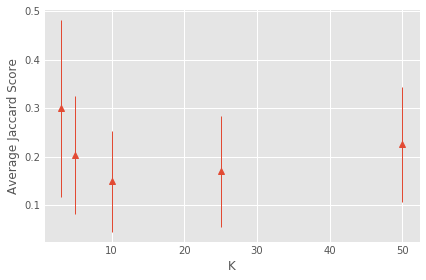

In [92]:
plt.style.use('ggplot')
plt.errorbar(ks,jacs,jacs_var, linestyle='None', marker='^', elinewidth = 1.0)
plt.xlabel('K')
plt.ylabel('Average Jaccard Score')
plt.show()

#### Diffusion Distance/Markov Transition Matrix Evaluation

In [75]:
ls = [0.1,0.5,1.0,10.0]
mars = np.zeros(len(ls))
mars_var = np.zeros(len(ls))
for i in range(0,len(ls)):
    print(ls[i])
    [mars[i], mars_var[i]] = markov_RMSE(ctrl_pre.T[sample],ctrl.T[sample],ls[i],ls[i])
    #print(np.mean(jaccard_score(ctrl_pre.T[sample],ctrl.T[sample],ks[i])))
    #mars[i] = np.mean(t)
    #mars_var[i] = np.std(t)

0.1


/Users/architverma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


0.5
1.0
10.0


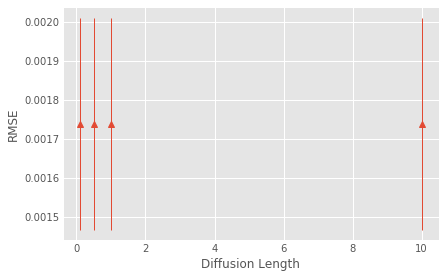

In [93]:
plt.errorbar(ls,mars,mars_var, linestyle='None', marker='^', elinewidth = 1.0)
plt.xlabel('Diffusion Length')
plt.ylabel('RMSE')
plt.show()